In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import cv2
import gc
from tqdm import tqdm
from PIL import Image
from glob import glob
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [2]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df['Binary Labels'] = all_xray_df['Finding Labels'].map(lambda x: 0.0 if x == 'No Finding' else 1.0)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
95044,00024762_000.png,No Finding,0,24762,35,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_011/images/00024762_000.png,0.0
57207,00014203_001.png,No Finding,1,14203,29,M,PA,2820,2897,0.143,0.143,NaN,../input/data/images_007/images/00014203_001.png,0.0
98037,00025858_001.png,Nodule,1,25858,32,F,AP,3056,2544,0.139,0.139,NaN,../input/data/images_011/images/00025858_001.png,1.0


In [3]:
print('Before sampling...')
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)

print('After sampling...')
all_xray_df = all_xray_df.sample(22000, random_state=25)
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)
all_xray_df.sample(3)

Before sampling...
0.0    60361
1.0    51759
Name: Binary Labels, dtype: int64
After sampling...
0.0    11764
1.0    10236
Name: Binary Labels, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
40711,00010563_024.png,No Finding,24,10563,34,M,PA,2706,2533,0.143000,0.143000,NaN,../input/data/images_005/images/00010563_024.png,0.0
111411,00030460_000.png,Infiltration,0,30460,53,M,PA,2021,2021,0.194311,0.194311,NaN,../input/data/images_012/images/00030460_000.png,1.0
74319,00018253_002.png,No Finding,2,18253,70,F,AP,2500,2048,0.168000,0.168000,NaN,../input/data/images_008/images/00018253_002.png,0.0


In [4]:
images = list(all_xray_df['path'])
labels = list(all_xray_df['Binary Labels'].map(lambda x: [x]))
train_img, val_img, train_label, val_label = train_test_split(images, labels, 
                                   test_size = 0.2, 
                                   random_state = 7,
                                   stratify = labels)
print('train:', len(train_img), '\nvalidation:', len(val_img))

train: 17600 
validation: 4400


In [5]:
class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.Linear_layer = nn.Sequential(nn.Linear(2048, 4096), 
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(4096, 2048),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(2048, 1024),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(1024, 512),
                                              nn.ReLU(),
                                              nn.Linear(512, 1))
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        x = self.out(x)
        return x

In [8]:
class my_set(Dataset):
    def __init__(self,Data,Label,transform=None):
        self.images = Data
        self.label = Label
        self.transform = transform
        
    def __getitem__(self, index):
        label = self.label[index]
        temp = cv2.imread(self.images[index])
        temp = np.array(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
        #print(self.images[index])
        try:
          temp = (temp * 255).round().astype(np.uint8)
        except:
          print(self.images[index])
        img = Image.fromarray(temp)
        if self.transform:
          img = self.transform(img)
        label = torch.Tensor([label])
        label = label.to(torch.float)
        return img, label
        
    def __len__(self):
        return len(self.images)

my_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

In [9]:
model = models.resnet152(pretrained=True)
model = Net(model)
print(model)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Net(
  (resnet_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64,

In [10]:
train = my_set(train_img, train_label, transform = my_transform)
trainloader = DataLoader(train, batch_size=16, shuffle=True, num_workers = 2)

val = my_set(val_img, val_label, transform = my_transform)
validloader = DataLoader(val, batch_size=16, shuffle=False, num_workers = 2)


valid_loss_min = np.Inf # track change in validation loss
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0002, momentum = 0.9 ,weight_decay=0.00002 )
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0002, weight_decay=0.00002 )
n_epochs = 10

train_ac = []
test_ac = []
t_loss = []
v_loss = []

In [11]:
print('CUDA:',torch.version.cuda)
device = torch.device("cuda")
model = model.to(device)
print(device)
gc.collect()
torch.cuda.empty_cache()

CUDA: 11.3
cuda


In [12]:
def training_loop(model):
    for epoch in tqdm(range(1, n_epochs+1)):
        train_loss = 0.0
        valid_loss = 0.0
        print('running epoch: {}'.format(epoch))
        model.train()
        train_correct = 0
        train_total = 0
        for data, target in trainloader:
            target = target.squeeze(1)
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_total += target.size(0)
            predicted = (output>0.5).float()
            train_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()

        # validate the model
        model.eval()
        valid_correct = 0
        valid_total = 0
        for data, target in validloader:
            target = target.squeeze(1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_total += target.size(0)
            predicted = (output>0.5).float()
            valid_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()
        # calculate average losses
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(validloader.dataset)
        t_loss.append(train_loss)
        v_loss.append(valid_loss)
        train_ac.append(100 * train_correct / train_total)
        test_ac.append(100 * valid_correct / valid_total) 

        print('Train Loss: {}'.format(train_loss))
        print('Validation Loss: {}'.format(valid_loss))
        print('Train Accuracy: {}'.format(100 * train_correct / train_total))
        print('Validation Accuracy: {}'.format(100 * valid_correct / valid_total))

In [13]:
training_loop(model)

  0%|          | 0/10 [00:00<?, ?it/s]

running epoch: 1


 10%|█         | 1/10 [21:19<3:11:59, 1279.89s/it]

Train Loss: 0.6788007483157245
Validation Loss: 0.7021642357652838
Train Accuracy: 57.28409090909091
Validation Accuracy: 58.13636363636363
running epoch: 2


 20%|██        | 2/10 [42:09<2:48:17, 1262.18s/it]

Train Loss: 0.6475821508602663
Validation Loss: 0.6868506919253956
Train Accuracy: 63.66477272727273
Validation Accuracy: 57.02272727272727
running epoch: 3


 30%|███       | 3/10 [1:03:05<2:26:56, 1259.46s/it]

Train Loss: 0.6369918903708458
Validation Loss: 0.6417920854958621
Train Accuracy: 64.80113636363636
Validation Accuracy: 64.43181818181819
running epoch: 4


 40%|████      | 4/10 [1:24:10<2:06:07, 1261.31s/it]

Train Loss: 0.6309580218521031
Validation Loss: 0.6176880750872872
Train Accuracy: 65.6534090909091
Validation Accuracy: 67.0
running epoch: 5


 50%|█████     | 5/10 [1:45:11<1:45:07, 1261.53s/it]

Train Loss: 0.622558511170474
Validation Loss: 0.6116182921149514
Train Accuracy: 66.53977272727273
Validation Accuracy: 67.22727272727273
running epoch: 6


 60%|██████    | 6/10 [2:05:39<1:23:19, 1249.95s/it]

Train Loss: 0.6175624345107512
Validation Loss: 0.6103408500281248
Train Accuracy: 67.08522727272727
Validation Accuracy: 68.31818181818181
running epoch: 7


 70%|███████   | 7/10 [2:26:04<1:02:05, 1241.80s/it]

Train Loss: 0.6149432662129403
Validation Loss: 0.669551114060662
Train Accuracy: 67.2784090909091
Validation Accuracy: 64.25
running epoch: 8


 80%|████████  | 8/10 [2:46:52<41:27, 1243.72s/it]  

Train Loss: 0.6134253779595549
Validation Loss: 0.6230313189463182
Train Accuracy: 67.46022727272727
Validation Accuracy: 67.36363636363636
running epoch: 9


 90%|█████████ | 9/10 [3:07:59<20:51, 1251.15s/it]

Train Loss: 0.6108585330031134
Validation Loss: 0.6223940335620534
Train Accuracy: 67.7784090909091
Validation Accuracy: 66.63636363636364
running epoch: 10


100%|██████████| 10/10 [3:28:45<00:00, 1252.55s/it]

Train Loss: 0.6092453255978497
Validation Loss: 0.6103797334974462
Train Accuracy: 67.91477272727273
Validation Accuracy: 68.13636363636364


In [14]:
test_correct = 0
test_total = 0
pred_label = []
pred_for_roc_curve = []
for data, target in validloader:
    target = target.squeeze(1)
    data, target = data.to(device), target.to(device)
    out = model(data)
    predicted = (out>0.5).float()
    pred_label.extend(predicted.tolist())
    pred_for_roc_curve.extend(out.tolist())
    test_correct += (predicted == target).sum().item()
    test_total += target.size(0)
    del data
    gc.collect()
    torch.cuda.empty_cache()
print('Testing Auccracy: {}'.format((100 * test_correct / test_total)))
acu = (100 * test_correct / test_total)

Testing Auccracy: 68.75


In [15]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
model_confusion_matrix = confusion_matrix(val_label, pred_label)
model_confusion_matrix

array([[1700,  653],
       [ 722, 1325]])

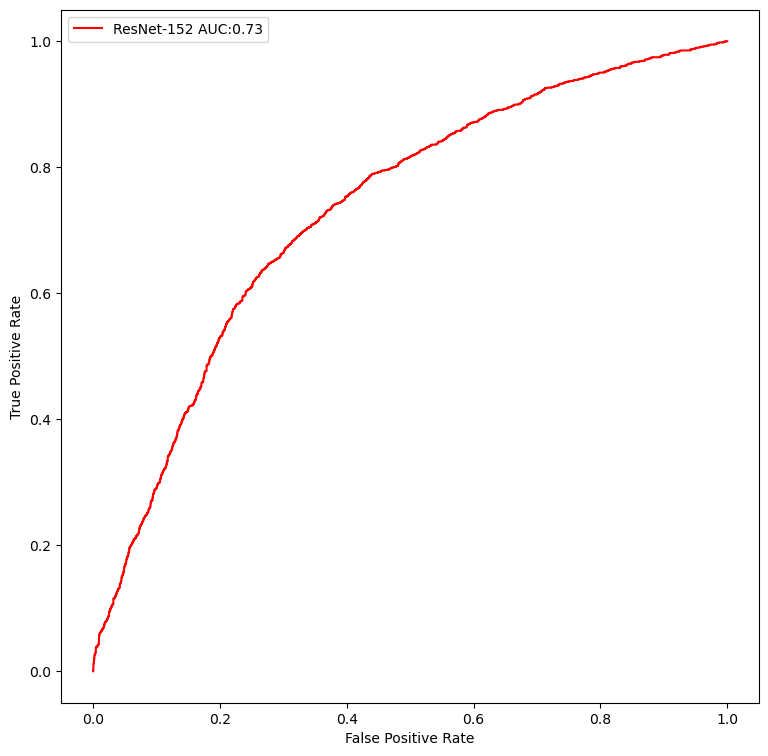

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score as acc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
fpr, tpr, thresholds = roc_curve(val_label, pred_for_roc_curve)
c_ax.plot(fpr, tpr, color='red', label = 'ResNet-152 AUC:%0.2f'  % (auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig("plot1.png")

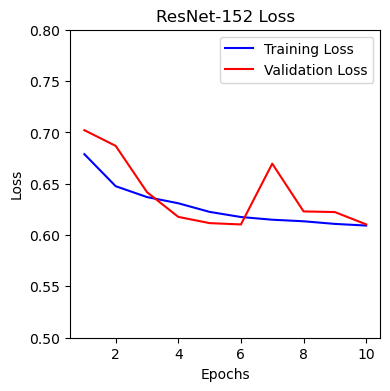

In [21]:
fig, c_ax = plt.subplots(1,1, figsize = (4, 4))
y = np.arange(1, n_epochs + 1)
c_ax.plot(y, t_loss, color='blue', label = 'Training Loss')
c_ax.plot(y, v_loss, color='red', label = 'Validation Loss')
c_ax.legend()
c_ax.set_title("ResNet-152 Loss")
c_ax.set_xlabel('Epochs')
plt.ylim([0.5, 0.8])
c_ax.set_ylabel('Loss')
plt.savefig("plot2.png")

[0.0]
[1.0]
[1.0]
[0.0]
[1.0]
[0.0]
[0.0]
[1.0]


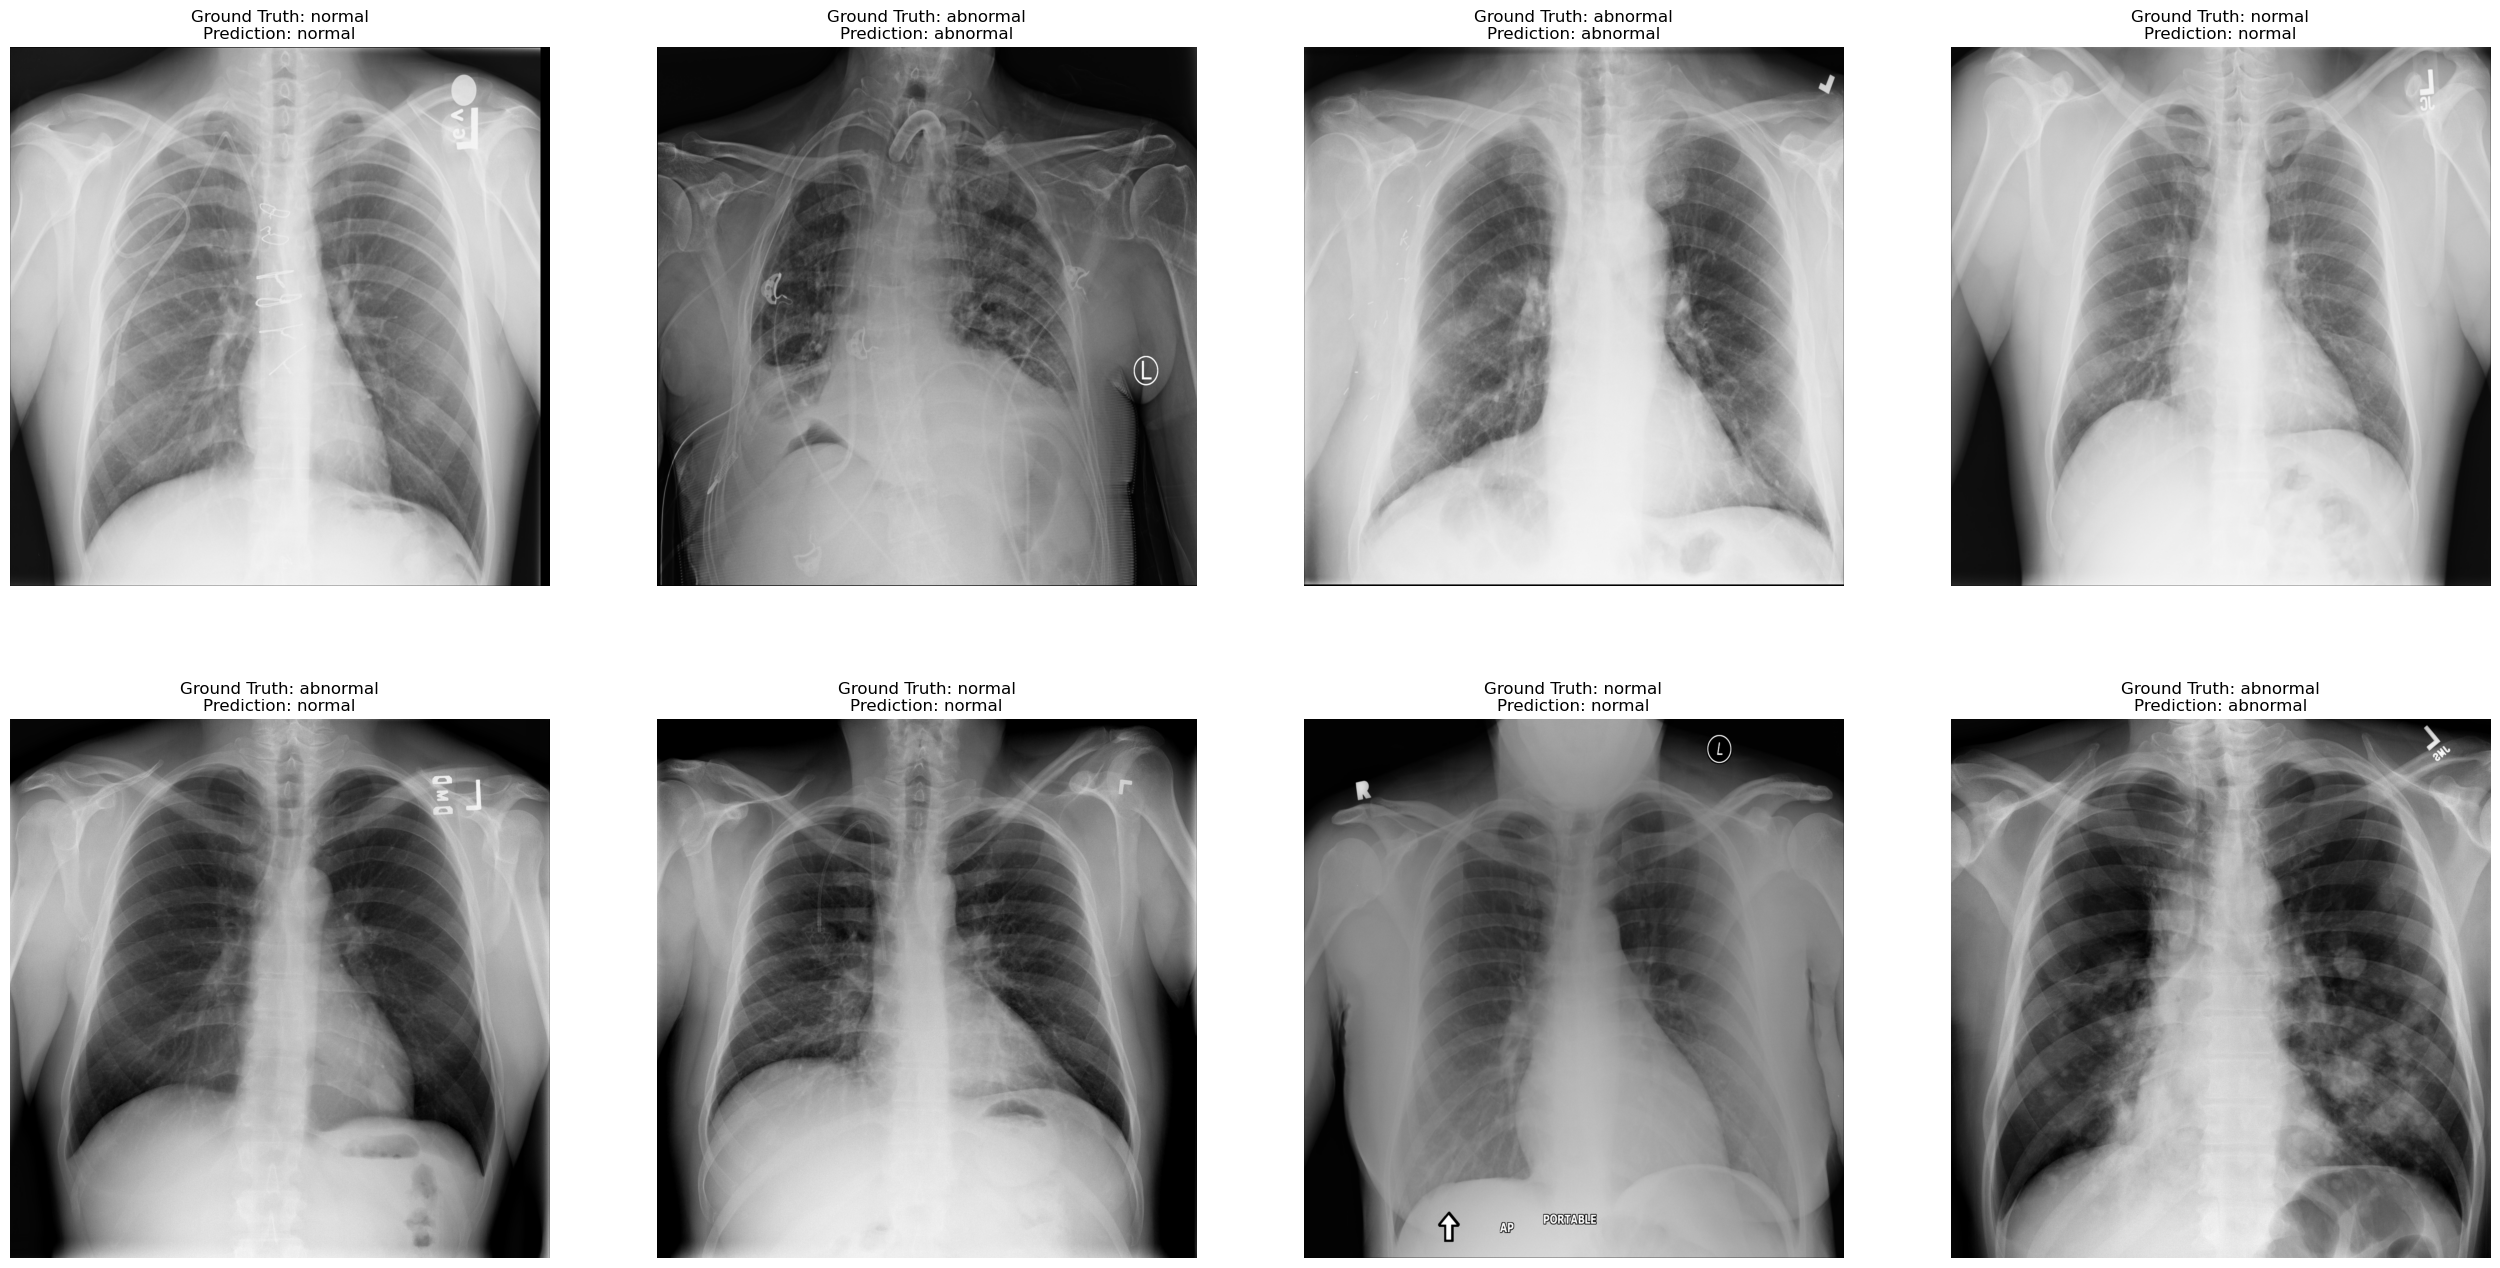

In [29]:
import random
idx = [random.randint(0, len(pred_label)) for _ in range(8)]
fig, m_axs = plt.subplots(2, 4, figsize = (32, 16))
for (temp, c_ax) in zip(idx, m_axs.flatten()):
    str_val = ""
    str_pred = ""
    print(val_label[temp])
    
    if (str(val_label[temp]) == '[1.0]'):
        str_val = "abnormal"
    else:
        str_val = "normal"
        
    if (str(pred_label[temp]) == '[1.0]'):
        str_pred = "abnormal"
    else:
        str_pred = "normal"
    
    c_ax.imshow(cv2.imread(val_img[temp]), cmap = 'bone')
    c_ax.set_title('Ground Truth: '+ str_val +'\nPrediction: ' +  str_pred)
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

import random
import cv2 
idx = [random.randint(0, len(pred_label)) for _ in range(8)]
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (temp, c_ax) in zip(idx, m_axs.flatten()):
    c_ax.imshow(cv2.imread(val_img[temp]), cmap = 'bone')
    c_ax.set_title('Ground Truth: '+ str(val_label[temp]) +'\nPrediction: ' +  str(pred_label[temp]))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')